## Common Imports and initialization

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit import IfElseOp
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

sim_backend = Aer.get_backend('aer_simulator')
QiskitRuntimeService.save_account(
    token="YOUR_API_TOKEN",
    instance="open-instance",
    overwrite=True
)
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
if "if_else" not in backend.target:
    backend.target.add_instruction(IfElseOp, name="if_else")

print(f"Using backend: {backend.name}")
print(f"Backend configuration: {backend.configuration().n_qubits} qubits")


# SECTION 1: AER SIMULATIONS 

## Problem 1: BB84 Quantum Key Distribution


### Part 1A: Manual BB84 Protocol (100 bits)

In [42]:
np.random.seed(42)
bit_num_full = 100
alice_bits = np.random.randint(0, 2, bit_num_full)
alice_bases = np.random.randint(0, 2, bit_num_full)
bob_bases = np.random.randint(0, 2, bit_num_full)
print(f"\nAlice's bits: {alice_bits[:]}")
print(f"Alice's bases: {alice_bases[:]}")
print(f"Bob's bases: {bob_bases[:]}")


Alice's bits: [0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1
 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0]
Alice's bases: [0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0
 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]
Bob's bases: [0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1
 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1]


In [43]:
# Simulate Bob's measurements algorithmically
bob_bits = np.zeros(bit_num_full, dtype=int)
for i in range(bit_num_full):
    if alice_bases[i] == bob_bases[i]:
        bob_bits[i] = alice_bits[i]
    else:
        bob_bits[i] = np.random.randint(0, 2)

print(f"Bob's results: {bob_bits[:]}")

Bob's results: [0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0
 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0]


In [44]:
sifted_alice = []
sifted_bob = []

for i in range(bit_num_full):
    if alice_bases[i] == bob_bases[i]:
        sifted_alice.append(alice_bits[i])
        sifted_bob.append(bob_bits[i])

sifted_alice= np.array(sifted_alice)
sifted_bob= np.array(sifted_bob)

print(f"\nMatching bases: {len(sifted_alice)} out of {bit_num_full}")
print(f"Sifted Alice key: {sifted_alice[:]}")
print(f"Sifted Bob key: {sifted_bob[:]}")
print(f"\nKey match rate: {np.sum(sifted_alice == sifted_bob) / len(sifted_alice) * 100:.2f}%")


Matching bases: 47 out of 100
Sifted Alice key: [0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1
 0 0 1 1 1 1 1 1 1 1]
Sifted Bob key: [0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1
 0 0 1 1 1 1 1 1 1 1]

Key match rate: 100.00%


In [45]:
message = "IBM"
encrypted_bits = []

for char in message:
    binary = [int(b) for b in format(ord(char), '08b')]
    encrypted_bits.extend(binary)

encrypted_bits = np.array(encrypted_bits)
key_to_use = sifted_alice[:len(encrypted_bits)]
encrypted_message = (encrypted_bits + key_to_use) % 2

# Bob decrypts
decrypted_bits = (encrypted_message + sifted_bob[:len(encrypted_bits)]) % 2
decrypted_message = ""
for i in range(0, len(decrypted_bits), 8):
    byte = decrypted_bits[i:i+8]
    decrypted_message += chr(int(''.join(map(str, byte)), 2))

print(f"\nOriginal message: {message}")
print(f"Decrypted message: {decrypted_message}")


Original message: IBM
Decrypted message: IBM


### Part 1B: Quantum Circuit on AER (10 bits)


Alice's bits: [0 1 0 0 0 1 0 0 0 1]
Alice's bases: [0 1 1 1 1 1 1 1 1 0]
Bob's bases: [0 1 0 0 1 0 1 1 1 0]

Circuit created


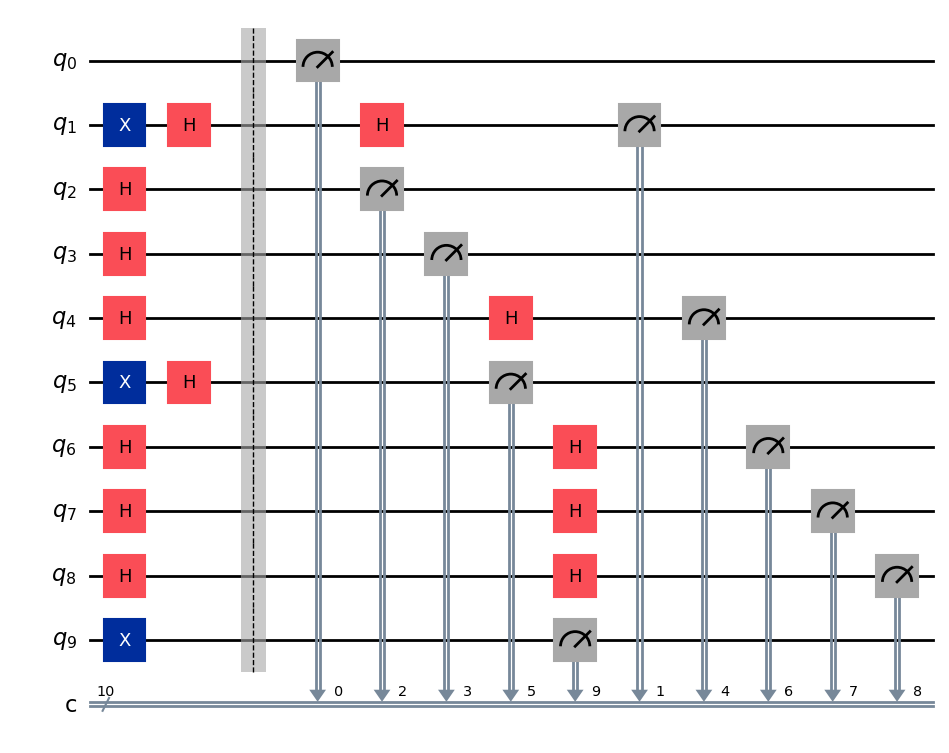

In [46]:
bit_num_quantum = 10
alice_bits_aer = alice_bits[:bit_num_quantum]
alice_bases_aer = alice_bases[:bit_num_quantum]
bob_bases_aer = bob_bases[:bit_num_quantum]
print(f"\nAlice's bits: {alice_bits_aer}")
print(f"Alice's bases: {alice_bases_aer}")
print(f"Bob's bases: {bob_bases_aer}")

qc = QuantumCircuit(bit_num_quantum, bit_num_quantum)
for i in range(bit_num_quantum):
    if alice_bits_aer[i] == 1:
        qc.x(i)
    if alice_bases_aer[i] == 1:
        qc.h(i)

qc.barrier()
for i in range(bit_num_quantum):
    if bob_bases_aer[i] == 1:
        qc.h(i)
    qc.measure(i, i)

print("\nCircuit created")
display(qc.draw('mpl'))

In [47]:
tqc = transpile(qc, sim_backend)
result = sim_backend.run(tqc, shots=1).result()
counts = result.get_counts()

bob_results_str = list(counts.keys())[0]
bob_bits_aer = np.array([int(b) for b in bob_results_str[::-1]])

print(f"\nBob's measurement results: {bob_bits_aer}")
sifted_alice_aer = []
sifted_bob_aer = []

for i in range(bit_num_quantum):
    if alice_bases_aer[i] == bob_bases_aer[i]:
        sifted_alice_aer.append(alice_bits_aer[i])
        sifted_bob_aer.append(bob_bits_aer[i])

sifted_alice_aer = np.array(sifted_alice_aer)
sifted_bob_aer = np.array(sifted_bob_aer)

print(f"\nMatching bases: {len(sifted_alice_aer)} out of {bit_num_quantum}")
print(f"Sifted Alice key: {sifted_alice_aer}")
print(f"Sifted Bob key: {sifted_bob_aer}")


Bob's measurement results: [0 1 1 0 0 1 0 0 0 1]

Matching bases: 7 out of 10
Sifted Alice key: [0 1 0 0 0 0 1]
Sifted Bob key: [0 1 0 0 0 0 1]


## Problem 2: Standard Quantum Teleportation - AER Simulation

Teleport a quantum state $|\psi\rangle = 0.6|0\rangle + 0.8|1\rangle$ from Alice to Bob.

**Bell state used**: $|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$

State to teleport: 0.6|0⟩ + 0.8|1⟩
Bell state: |Φ+⟩ = (|00⟩ + |11⟩)/√2


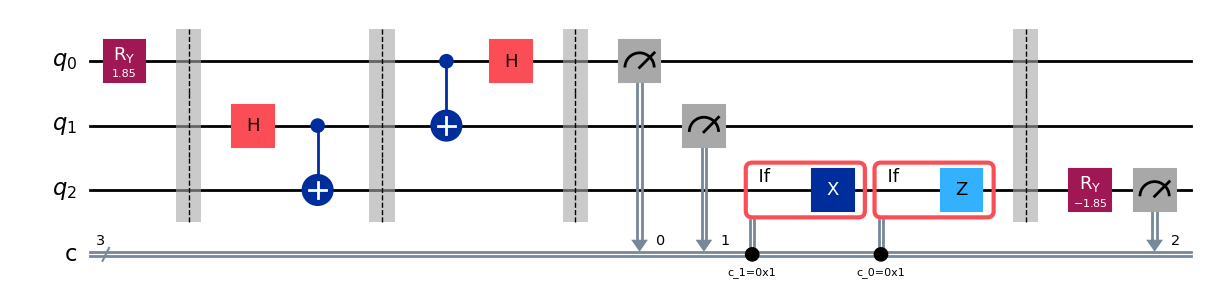

In [48]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
qc_teleport = QuantumCircuit(q, c)

alpha = 0.6
beta = 0.8
theta = 2 * np.arccos(alpha)
qc_teleport.ry(theta, q[0])

print(f"State to teleport: {alpha}|0⟩ + {beta}|1⟩")
print(f"Bell state: |Φ+⟩ = (|00⟩ + |11⟩)/√2")

qc_teleport.barrier()

qc_teleport.h(q[1])
qc_teleport.cx(q[1], q[2])
qc_teleport.barrier()

qc_teleport.cx(q[0], q[1])
qc_teleport.h(q[0])
qc_teleport.barrier()

qc_teleport.measure(q[0], c[0])
qc_teleport.measure(q[1], c[1])

with qc_teleport.if_test((c[1], 1)):
    qc_teleport.x(q[2])
with qc_teleport.if_test((c[0], 1)):
    qc_teleport.z(q[2])

qc_teleport.barrier()

qc_teleport.ry(-theta, q[2])
qc_teleport.measure(q[2], c[2])

display(qc_teleport.draw('mpl'))

Teleportation results (AER):


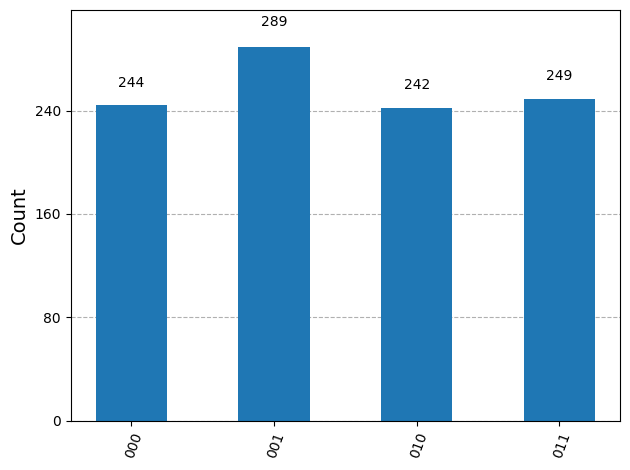

In [49]:
tqc_teleport = transpile(qc_teleport, sim_backend)
result_teleport = sim_backend.run(tqc_teleport, shots=1024).result()
counts_teleport = result_teleport.get_counts()

print("Teleportation results (AER):")
display(plot_histogram(counts_teleport))

## Problem 3: GHZ-based Quantum Teleportation - AER Simulation

Teleport a quantum state using a GHZ-like entangled state shared among Alice, Bob, and Charlie.

**GHZ-like state**: $\frac{1}{2}(|001\rangle + |010\rangle + |100\rangle + |111\rangle)$

State to teleport: 0.6|0⟩ + 0.8|1⟩
GHZ-like state: (|001⟩ + |010⟩ + |100⟩ + |111⟩)/2


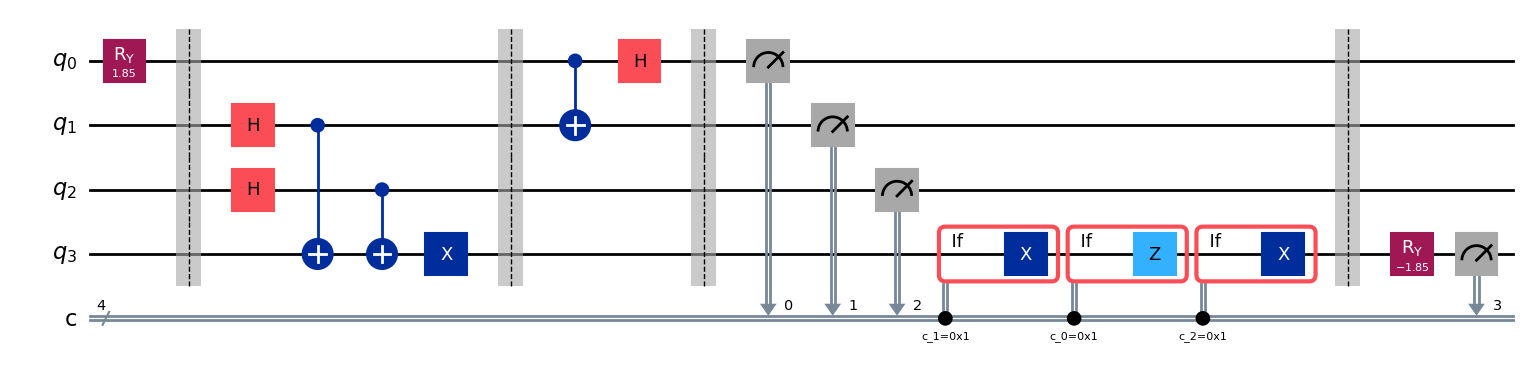

In [50]:
q_ghz = QuantumRegister(4, 'q')
c_ghz = ClassicalRegister(4, 'c')
qc_ghz = QuantumCircuit(q_ghz, c_ghz)

alpha_ghz = 0.6
beta_ghz = 0.8
theta_ghz = 2 * np.arccos(alpha_ghz)
qc_ghz.ry(theta_ghz, q_ghz[0])

print(f"State to teleport: {alpha_ghz}|0⟩ + {beta_ghz}|1⟩")
print("GHZ-like state: (|001⟩ + |010⟩ + |100⟩ + |111⟩)/2")

qc_ghz.barrier()

qc_ghz.h(q_ghz[1])
qc_ghz.h(q_ghz[2])
qc_ghz.cx(q_ghz[1], q_ghz[3])
qc_ghz.cx(q_ghz[2], q_ghz[3])
qc_ghz.x(q_ghz[3])
qc_ghz.barrier()

qc_ghz.cx(q_ghz[0], q_ghz[1])
qc_ghz.h(q_ghz[0])
qc_ghz.barrier()

qc_ghz.measure(q_ghz[0], c_ghz[0])
qc_ghz.measure(q_ghz[1], c_ghz[1])
qc_ghz.measure(q_ghz[2], c_ghz[2])

with qc_ghz.if_test((c_ghz[1], 1)):
    qc_ghz.x(q_ghz[3])
with qc_ghz.if_test((c_ghz[0], 1)):
    qc_ghz.z(q_ghz[3])
with qc_ghz.if_test((c_ghz[2], 1)):
    qc_ghz.x(q_ghz[3])

qc_ghz.barrier()

qc_ghz.ry(-theta_ghz, q_ghz[3])
qc_ghz.measure(q_ghz[3], c_ghz[3])

display(qc_ghz.draw('mpl'))

GHZ-based teleportation results (AER):


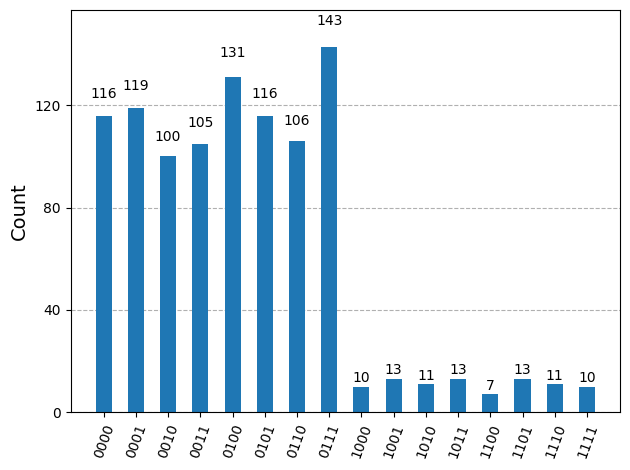


Success rate (AER): 91.41%


In [51]:
tqc_ghz = transpile(qc_ghz, sim_backend)
result_ghz = sim_backend.run(tqc_ghz, shots=1024).result()
counts_ghz = result_ghz.get_counts()

print("GHZ-based teleportation results (AER):")
display(plot_histogram(counts_ghz))

# Analyze
successful_ghz = sum(count for bitstring, count in counts_ghz.items() if bitstring[0] == '0')
success_rate_ghz = successful_ghz / 1024 * 100
print(f"\nSuccess rate (AER): {success_rate_ghz:.2f}%")


# SECTION 2: IBM QPU EXECUTIONS

## Problem 1: BB84 QKD - IBM QPU Execution

In [54]:
# Use same 10 bits for comparison
alice_bits_ibm = alice_bits[:bit_num_quantum]
alice_bases_ibm = alice_bases[:bit_num_quantum]
bob_bases_ibm = bob_bases[:bit_num_quantum]

print(f"\nAlice's bits: {alice_bits_ibm}")
print(f"Alice's bases: {alice_bases_ibm}")
print(f"Bob's bases: {bob_bases_ibm}")

qc_ibm = QuantumCircuit(bit_num_quantum, bit_num_quantum)

for i in range(bit_num_quantum):
    if alice_bits_ibm[i] == 1:
        qc_ibm.x(i)
    if alice_bases_ibm[i] == 1:
        qc_ibm.h(i)

qc_ibm.barrier()

for i in range(bit_num_quantum):
    if bob_bases_ibm[i] == 1:
        qc_ibm.h(i)
    qc_ibm.measure(i, i)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
qc_ibm_transpiled = pm.run(qc_ibm)



Alice's bits: [0 1 0 0 0 1 0 0 0 1]
Alice's bases: [0 1 1 1 1 1 1 1 1 0]
Bob's bases: [0 1 0 0 1 0 1 1 1 0]


In [55]:
alice_bits_ibm = alice_bits[:bit_num_quantum]
alice_bases_ibm = alice_bases[:bit_num_quantum]
bob_bases_ibm = bob_bases[:bit_num_quantum]

print(f"\nAlice's bits: {alice_bits_ibm}")
print(f"Alice's bases: {alice_bases_ibm}")
print(f"Bob's bases: {bob_bases_ibm}")

qc_ibm = QuantumCircuit(bit_num_quantum, bit_num_quantum)

for i in range(bit_num_quantum):
    if alice_bits_ibm[i] == 1:
        qc_ibm.x(i)
    if alice_bases_ibm[i] == 1:
        qc_ibm.h(i)

qc_ibm.barrier()

for i in range(bit_num_quantum):
    if bob_bases_ibm[i] == 1:
        qc_ibm.h(i)
    qc_ibm.measure(i, i)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
qc_ibm_transpiled = pm.run(qc_ibm)



Alice's bits: [0 1 0 0 0 1 0 0 0 1]
Alice's bases: [0 1 1 1 1 1 1 1 1 0]
Bob's bases: [0 1 0 0 1 0 1 1 1 0]


In [56]:
sampler = Sampler(mode=backend)
job = sampler.run([qc_ibm_transpiled], shots=1)
print(f"Job ID: {job.job_id()}")

results = job.result()
meas_data = results[0].data
if hasattr(meas_data, 'c'):
    bitstring = meas_data.c.get_bitstrings()[0]
elif hasattr(meas_data, 'meas'):
    bitstring = meas_data.meas.get_bitstrings()[0]
else:
    reg_name = list(vars(meas_data).keys())[0]
    bitstring = getattr(meas_data, reg_name).get_bitstrings()[0]

bob_bits_ibm = np.array([int(b) for b in str(bitstring)[::-1]])

sifted_alice_ibm = []
sifted_bob_ibm = []

for i in range(bit_num_quantum):
    if alice_bases_ibm[i] == bob_bases_ibm[i]:
        sifted_alice_ibm.append(alice_bits_ibm[i])
        sifted_bob_ibm.append(bob_bits_ibm[i])

sifted_alice_ibm = np.array(sifted_alice_ibm)
sifted_bob_ibm = np.array(sifted_bob_ibm)

print(f"\nMatching bases: {len(sifted_alice_ibm)}")
print(f"Sifted Alice key: {sifted_alice_ibm}")
print(f"Sifted Bob key: {sifted_bob_ibm}")
print(f"\nKey match rate: {np.sum(sifted_alice_ibm == sifted_bob_ibm) / len(sifted_alice_ibm) * 100:.2f}%")

Job ID: d65ha0dbujdc73ctfdug

Matching bases: 7
Sifted Alice key: [0 1 0 0 0 0 1]
Sifted Bob key: [0 1 0 0 0 0 1]

Key match rate: 100.00%


## Problem 2: Standard Quantum Teleportation - IBM QPU Execution

In [57]:
q_ibm = QuantumRegister(3, 'q')
c_ibm = ClassicalRegister(3, 'c')
qc_teleport_ibm = QuantumCircuit(q_ibm, c_ibm)

qc_teleport_ibm.ry(theta, q_ibm[0])
qc_teleport_ibm.barrier()

qc_teleport_ibm.h(q_ibm[1])
qc_teleport_ibm.cx(q_ibm[1], q_ibm[2])
qc_teleport_ibm.barrier()

qc_teleport_ibm.cx(q_ibm[0], q_ibm[1])
qc_teleport_ibm.h(q_ibm[0])
qc_teleport_ibm.barrier()

qc_teleport_ibm.measure(q_ibm[0], c_ibm[0])
qc_teleport_ibm.measure(q_ibm[1], c_ibm[1])

with qc_teleport_ibm.if_test((c_ibm[1], 1)):
    qc_teleport_ibm.x(q_ibm[2])
with qc_teleport_ibm.if_test((c_ibm[0], 1)):
    qc_teleport_ibm.z(q_ibm[2])

qc_teleport_ibm.barrier()
qc_teleport_ibm.ry(-theta, q_ibm[2])
qc_teleport_ibm.measure(q_ibm[2], c_ibm[2])
pm_teleport = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_teleport_ibm_transpiled = pm_teleport.run(qc_teleport_ibm)

Job ID: d65hab3e4kfs73c46oug


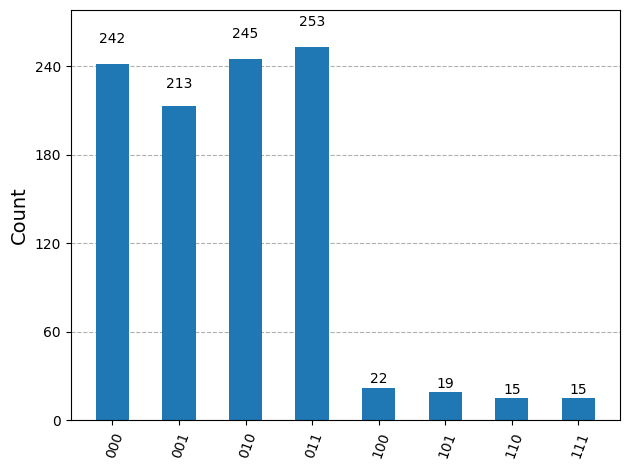


Success rate : 93.07%


In [58]:
sampler_teleport = Sampler(mode=backend)
job_teleport = sampler_teleport.run([qc_teleport_ibm_transpiled], shots=1024)
print(f"Job ID: {job_teleport.job_id()}")

results_teleport_ibm = job_teleport.result()
counts_teleport_ibm = results_teleport_ibm[0].data.c.get_counts()
display(plot_histogram(counts_teleport_ibm))
successful_teleport_ibm = sum(count for bitstring, count in counts_teleport_ibm.items() if bitstring[0] == '0')
success_rate_teleport_ibm = successful_teleport_ibm / 1024 * 100
print(f"\nSuccess rate : {success_rate_teleport_ibm:.2f}%")

## Problem 3: GHZ-based Quantum Teleportation - IBM QPU Execution

In [59]:
q_ghz_ibm = QuantumRegister(4, 'q')
c_ghz_ibm = ClassicalRegister(4, 'c')
qc_ghz_ibm = QuantumCircuit(q_ghz_ibm, c_ghz_ibm)

qc_ghz_ibm.ry(theta_ghz, q_ghz_ibm[0])
qc_ghz_ibm.barrier()

qc_ghz_ibm.h(q_ghz_ibm[1])
qc_ghz_ibm.h(q_ghz_ibm[2])
qc_ghz_ibm.cx(q_ghz_ibm[1], q_ghz_ibm[3])
qc_ghz_ibm.cx(q_ghz_ibm[2], q_ghz_ibm[3])
qc_ghz_ibm.x(q_ghz_ibm[3])
qc_ghz_ibm.barrier()

qc_ghz_ibm.cx(q_ghz_ibm[0], q_ghz_ibm[1])
qc_ghz_ibm.h(q_ghz_ibm[0])
qc_ghz_ibm.barrier()

qc_ghz_ibm.measure(q_ghz_ibm[0], c_ghz_ibm[0])
qc_ghz_ibm.measure(q_ghz_ibm[1], c_ghz_ibm[1])
qc_ghz_ibm.measure(q_ghz_ibm[2], c_ghz_ibm[2])

with qc_ghz_ibm.if_test((c_ghz_ibm[1], 1)):
    qc_ghz_ibm.x(q_ghz_ibm[3])
with qc_ghz_ibm.if_test((c_ghz_ibm[0], 1)):
    qc_ghz_ibm.z(q_ghz_ibm[3])
with qc_ghz_ibm.if_test((c_ghz_ibm[2], 1)):
    qc_ghz_ibm.x(q_ghz_ibm[3])

qc_ghz_ibm.barrier()
qc_ghz_ibm.ry(-theta_ghz, q_ghz_ibm[3])
qc_ghz_ibm.measure(q_ghz_ibm[3], c_ghz_ibm[3])

pm_ghz = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_ghz_ibm_transpiled = pm_ghz.run(qc_ghz_ibm)

Job ID: d65had1v6o8c73d302vg


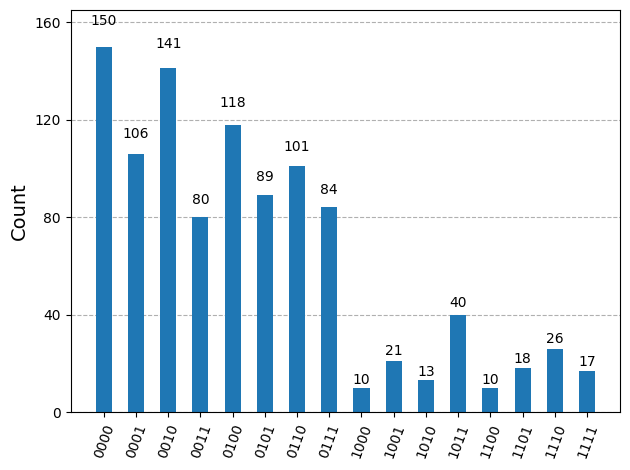


Success rate: 84.86%


In [60]:
sampler_ghz = Sampler(mode=backend)
job_ghz = sampler_ghz.run([qc_ghz_ibm_transpiled], shots=1024)
print(f"Job ID: {job_ghz.job_id()}")
results_ghz_ibm = job_ghz.result()
counts_ghz_ibm = results_ghz_ibm[0].data.c.get_counts()

display(plot_histogram(counts_ghz_ibm))

successful_ghz_ibm = sum(count for bitstring, count in counts_ghz_ibm.items() if bitstring[0] == '0')
success_rate_ghz_ibm = successful_ghz_ibm / 1024 * 100
print(f"\nSuccess rate: {success_rate_ghz_ibm:.2f}%")